# Risk-Stratified SHAP Networks

This notebook implements risk-stratified aggregation of SHAP values to identify different feature importance patterns across risk subgroups.

**Approach:** Stratify patients by predicted disease risk (low/high) and build separate networks for each group. This reveals how feature importance varies across risk levels.

**Mathematical Framework:**
- **Node weights** aggregate individual SHAP values across patients in each risk stratum
- **Edge weights** aggregate interaction values, with the denominator normalized using only the **lower triangular** interaction matrix (u > v), excluding diagonal elements

In [28]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

In [29]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [30]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

# Load y values (outcome/risk) from NHANES dataset
_, y = shap.datasets.nhanesi()
y_shapley = y[:num_patients]

## Stratify Patients by Actual Risk (y variable)

Use the actual outcome variable (y) to stratify patients into risk groups

In [31]:
from math import ceil

# Use actual outcome variable (y) for risk stratification
shap_values_clean = np.nan_to_num(shap_values)

# Stratify based on y values (actual disease outcome/risk)
# Sort and create tertiles based on y
sorted_indices = np.argsort(y_shapley)
n_low_risk = ceil(len(y_shapley) * 0.66)

low_risk_indices = sorted_indices[:n_low_risk]
high_risk_indices = sorted_indices[n_low_risk:]

# Create masks
low_risk_mask = np.isin(np.arange(len(y_shapley)), low_risk_indices)
high_risk_mask = np.isin(np.arange(len(y_shapley)), high_risk_indices)

# Display statistics
print(f"Risk stratification based on outcome variable (y):\n")
print(f"Low risk patients: {low_risk_mask.sum()}")
print(f"  y range: [{y_shapley[low_risk_indices].min():.4f}, {y_shapley[low_risk_indices].max():.4f}]")
print(f"  y mean: {y_shapley[low_risk_indices].mean():.4f}")

print(f"\nHigh risk patients: {high_risk_mask.sum()}")
print(f"  y range: [{y_shapley[high_risk_indices].min():.4f}, {y_shapley[high_risk_indices].max():.4f}]")
print(f"  y mean: {y_shapley[high_risk_indices].mean():.4f}")

Risk stratification based on outcome variable (y):

Low risk patients: 330
  y range: [-22.0833, -12.2500]
  y mean: -20.5359

High risk patients: 170
  y range: [-11.8333, 21.4167]
  y mean: 10.4657


## Function to Build Network for Risk Stratum

**Key Implementation Details:**

The function implements the following equations from the paper:

**Node weights (N*_i):**
$$\mathcal{N}^*_i = \frac{\sum_{t \in R_k} Sh_{i}(\Delta^{t})}{\sum_{u=1}^{n} \sum_{t \in R_k} |Sh_{u}(\Delta^{t})|}$$

**Edge weights (E*_ij):**
$$\mathcal{E}^*_{ij} = \frac{\sum_{t \in R_k} I_{ij}(\Delta^{t})}{\sum_{v=1}^{n} \sum_{u > v} \sum_{t \in R_k} |I_{uv}(\Delta^{t})|}$$

**Important:** The edge weight denominator sums only over the **lower triangular** part of the interaction matrix (where u > v), excluding diagonal elements. This differs from summing over all non-diagonal elements.

In [32]:
def build_network_for_stratum(patient_mask, shap_values, shap_interaction_values, X_shapley):
    """
    Build psi and r matrices for a specific patient stratum
    
    Implements equations:
    - Node weights: N*_i = sum_t(Sh_i) / sum_u sum_t |Sh_u|
    - Edge weights: E*_ij = sum_t(I_ij) / sum_v sum_{u>v} sum_t |I_uv|
      where u>v denotes the lower triangular matrix (excluding diagonal)
    """
    # Filter SHAP values for this stratum
    stratum_shap = shap_values[patient_mask]
    stratum_interaction = shap_interaction_values[patient_mask]
    
    # Calculate psi_1 (node weights)
    # Numerator: sum over patients for each feature
    # Denominator: sum of absolute values over all patients and all features
    sum_shap = np.sum(np.abs(stratum_shap), axis=(0, 1))
    psi_1 = pd.DataFrame()
    psi_1['value'] = np.sum(stratum_shap, axis=0) / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - use only lower triangular matrix for denominator
    n_patients_stratum = stratum_interaction.shape[0]
    n_variables = stratum_interaction.shape[1]
    
    # Clean NaN values
    filtered_interaction = np.nan_to_num(stratum_interaction.copy())
    
    # Create lower triangular mask (u > v means row > col, excluding diagonal)
    lower_tri_mask = np.tril(np.ones((n_variables, n_variables), dtype=bool), k=-1)
    
    # Calculate denominator: sum of absolute values of lower triangular elements only
    # sum_v sum_{u>v} sum_t |I_uv(Delta^t)|
    sum_interaction_lower = 0.0
    for patient_idx in range(n_patients_stratum):
        sum_interaction_lower += np.sum(np.abs(filtered_interaction[patient_idx][lower_tri_mask]))
    
    # Calculate numerator: sum over patients for each (i,j) pair
    # sum_t I_ij(Delta^t)
    cumulative_interaction = np.sum(filtered_interaction, axis=0)
    
    # Zero out diagonal (remove self-interactions)
    np.fill_diagonal(cumulative_interaction, 0)
    
    # Calculate edge weights: E*_ij = numerator / denominator
    r_1 = pd.DataFrame(cumulative_interaction / sum_interaction_lower)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

## Build Networks for Each Risk Stratum

In [33]:
# Build networks for each stratum
low_psi_1, low_r_1, low_psi_2, low_r_2 = build_network_for_stratum(
    low_risk_mask, shap_values_clean, shap_interaction_values, X_shapley
)

high_psi_1, high_r_1, high_psi_2, high_r_2 = build_network_for_stratum(
    high_risk_mask, shap_values_clean, shap_interaction_values, X_shapley
)

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization Setup

In [63]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

## Low Risk Network

Low Risk Patients Network


c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(filter_edge)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\visualization\graph.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adjacency = r.copy().applymap(lambda x: 1 if x != 0 else 0)


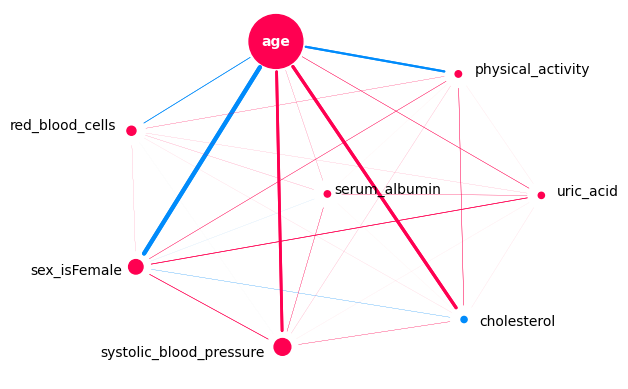

In [66]:
positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

print("Low Risk Patients Network")
draw(
    psi=low_psi_2,
    r=low_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## High Risk Network

High Risk Patients Network


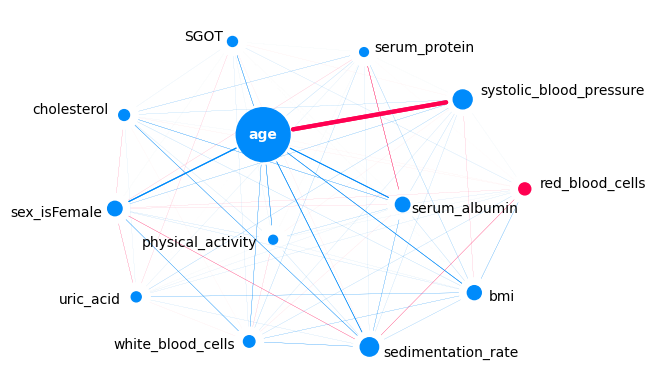

In [84]:
positive_alpha = 0.025
negative_alpha = 0.025
positive_beta = 0
negative_beta = 0

print("High Risk Patients Network")
draw(
    psi=high_psi_2,
    r=high_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)